In [1]:
import sys
sys.path.append('..')

import imageio
import matplotlib.pyplot as plt
from data import load

from util import *

import numpy as np
np.random.seed(123)

%load_ext autoreload
%autoreload 2

In [2]:
def P_M(u, m):
    """
    u: current iterate
    m: true magnitude
    """
    F_u = np.fft.fft2(u)
    F_u += (F_u == 0) # Multiply m by one for zero Fourier entries
    v0_hat = m * (F_u / np.abs(F_u))
    return np.real(np.fft.ifft2(v0_hat))

def P_Spos(u, m, D=None):
    """
    u: current iterate
    m: true magnitude
    D: support mask, None = full support
    """
    if D is None:
        return np.maximum(0, u)
    else:
        return np.maximum(0, u) * D

In [3]:
def RAAR(m, beta=0.8, steps=200, verbose=True, D=None):

    u = np.random.rand(*m.shape)
    
    R_M = lambda u: 2 * P_M(u, m) - u
    R_Spos = lambda u: 2 * P_Spos(u, m) - u  
    
    for s in range(steps):
        T = 0.5 * (R_Spos(R_M(u)) + u)
        u = beta * T + (1 - beta) * P_M(u, m)
    
    return np.real(u)

In [ ]:
size = 1024
restart = 3

beta = 0.87
stes = 1000

test_data = load(name='CelebA64', path='/home/shared/phase-retrieval/data/CelebA64.h5' ,batch_size=1024)[0]['test']
batch = next(iter(test_data)).numpy()[:size]
results = np.zeros_like(batch)
for i, image in enumerate(batch):
    if i % 100==0:
        print(i)
    magnitudes = np.abs(np.fft.fft2(image))
    res = []
    errors = []
    for _ in range(restart):
        res.append(RAAR(magnitudes, beta=beta, steps=stes, verbose=False))
        errors.append(np.mean((np.abs(np.fft.fft2(res[-1]))-magnitudes)**2))
    results[i] = res[np.argmin(errors)]

0
100
200
300
400
500
600
700
800


In [ ]:
### CACHE RESULTS ###

import pickle
pickle.dump(batch, open("/home/shared/phase-retrieval/test/RAAR_CelebA/original_1.p", "wb"))
pickle.dump(results, open("/home/shared/phase-retrieval/test/RAAR_CelebA/predicted_1.p", "wb"))

In [13]:
### LOAD RESULTS ###
import pickle

batch = pickle.load(open("/home/shared/phase-retrieval/test/RAAR_CelebA/original_1.p", "rb"))
results = pickle.load(open("/home/shared/phase-retrieval/test/RAAR_CelebA/predicted_1.p", "rb"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


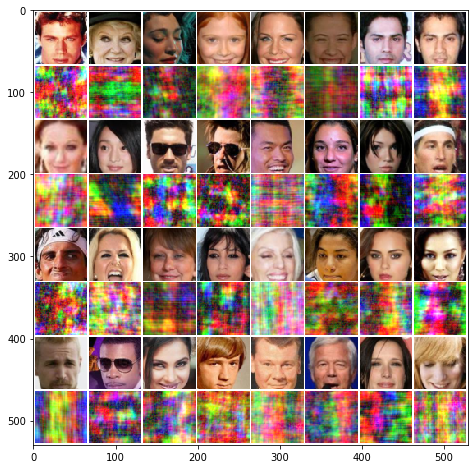

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


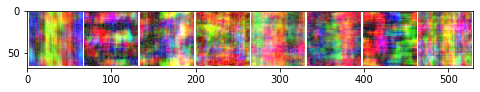

In [14]:
to_plot = np.stack([batch[:32].reshape(4, 8*3, 64, 64), 
                    results[:32].reshape(4, 8*3, 64, 64)], axis=1).reshape(-1, 3, 64, 64)
                
plot_grid(to_plot, figsize=(8,8), 
          file="../out/raar/CelebA_RAAR.png")

plot_grid(results[24:32].reshape(-1, 3, 64, 64), figsize=(8,8),
          file="../out/raar/CelebA_RAAR_small.png")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


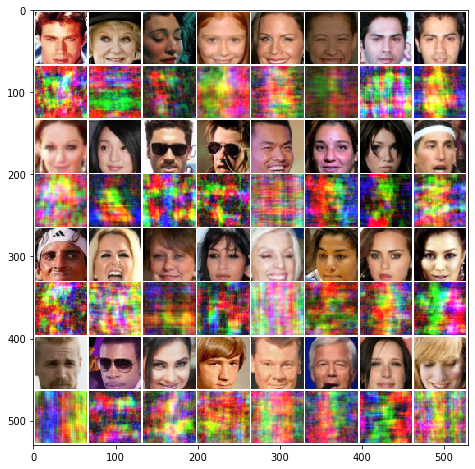

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


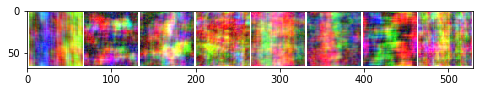

In [15]:
results_reg = register_croco(results, batch)

to_plot = np.stack([batch[:32].reshape(4, 8*3, 64, 64), 
                    results_reg[:32].reshape(4, 8*3, 64, 64)], axis=1).reshape(-1, 3, 64, 64)
                
plot_grid(to_plot, figsize=(8,8), 
          file="../out/raar/CelebA_RAAR_reg.png")

plot_grid(results_reg[24:32].reshape(-1, 3, 64, 64), figsize=(8,8),
          file="../out/raar/CelebA_RAAR_small_reg.png")

In [16]:
benchmark(results_reg, batch, check_all=True)

Signal error:
  MSE: 0.07293346914866561, std: 0.032329237127544534
  MAE: 0.20726552094856743, std: 0.04701780639220992
  SSIM: 0.22737939924966116, std: 0.05806915103095455
  Sharpness: 0.06519405770767758, std: 0.014185249804344068
  PhCo-MSE: 0.09772358351710864, std: 0.045096393430172764
  PhCo-MAE: 0.24209491054352839, std: 0.05891375227977056
  PhCo-SSIM: 0.174461544338164, std: 0.061762651566800775
  CroCo-MSE: 0.07293346914866561, std: 0.032329237127544534
  CroCo-MAE: 0.20726552094856743, std: 0.04701780639220992
  CroCo-SSIM: 0.22737939924966116, std: 0.05806915103095455

Magnitude error:
  MSE Magnitude: 3.469860950382486e-13, std: 1.1878848609485536e-13

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [0.00, 2.13] - should be in [0, 1]

Markdown table values:
 0.07293 | 0.2073 | 0.2274 | 0.06519 | 0.09772 | 0.2421 | 0.1745 | 0.07293 | 0.2073 | 0.2274 | 0.0000000000003470 |


## RAAR CelebA

| steps | restarts | beta | MSE | MAE | SSIM | SHRP | PhCo-MSE | PhCo-MAE | PhCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn | notes | 
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1000 | 3 | 0.87 | 0.07293 | 0.2073 | 0.2274 | 0.06519 | 0.09772 | 0.2421 | 0.1745 | 0.07293 | 0.2073 | 0.2274 | 0.0000000000003470 |